In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
%cd /home/naodell/work/hgcal/analysis

import os
import pickle
from glob import glob
from itertools import product

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import RegularPolygon, FancyArrowPatch
from tqdm.notebook import tqdm

import utils.geometry_tools as gt
import utils.plot_tools as pt

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})

/home/naodell/work/hgcal/analysis


In [4]:
# get the data
input_file = open('local_data/tc_data/output_0_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']


In [62]:
# Draw some events overlaid in the first wedge
cmap = matplotlib.cm.get_cmap('Reds')

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_zside == -1 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()

# get data from individual event
event_ix = events[:10]
#event_ix = 15340
event_tc = df_cut.loc[event_ix]

if isinstance(event_ix, int):
    group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
else:
    group_wafer = event_tc.groupby(['event', 'tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()
energy_max = wafer_sums.reset_index().groupby('event').max()
wafer_max = energy_max[['tc_waferu', 'tc_waferv']]

[5 3]
[6 0]


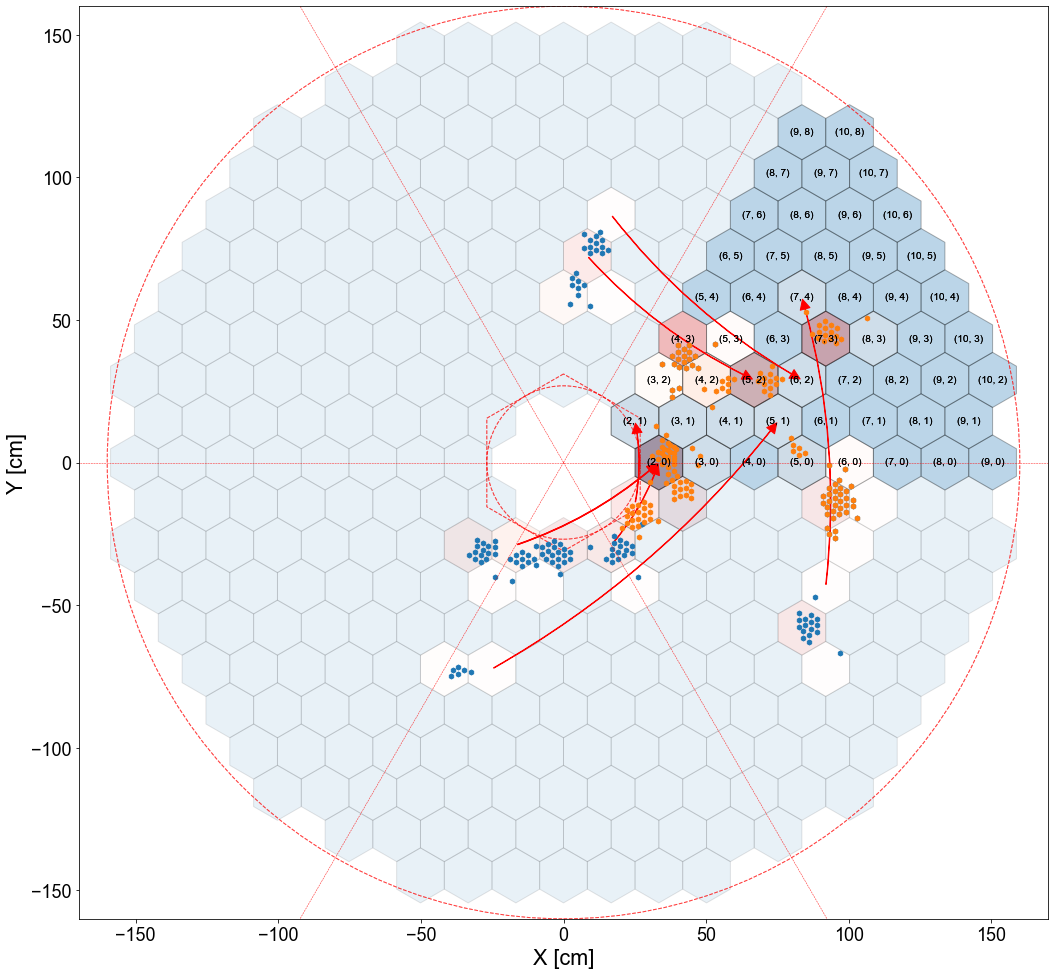

In [70]:
# plots demonstrating rotation of an event
fig, axes = plt.subplots(1, 1, figsize=(15, 15))

wafer_data = wafer_sums['tc_energy']
wafer_data_rot = dict()
event_iphi = dict() 
uv_init = dict()
for eix in event_ix:
    uv_max = wafer_max.loc[eix].values
    uv_init[eix] = uv_max
    wafer_rot, iphi = gt.map_to_first_wedge(uv_max, wafer_data.loc[eix])
    event_iphi[eix] = iphi
    #print(eix, uv_max, iphi)
    if iphi != 0:
        wafer_data_rot[eix] = pd.DataFrame(wafer_rot)
    else:
        print(uv_max)
    
uv_rot = np.array([gt.hex_rotation(uv_init[eix], -iphi) for eix, iphi in event_iphi.items()])
wafer_data_rot = pd.concat(wafer_data_rot)
                         
ax = axes
ax.set_aspect('equal')
wafer_data = event_tc.groupby(['tc_waferu', 'tc_waferv']).sum()['tc_energy']
pt.draw_hgcal_layer(ax, wafer_data, single_wedge=True, include_index=True)
wafer_data_rot = wafer_data_rot.groupby(['tc_waferu', 'tc_waferv']).sum()['tc_energy']
pt.draw_hgcal_layer(ax, wafer_data_rot, background_wafers=False, single_wedge=True, include_index=True)

tc_sums = event_tc.groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
tc_x, tc_y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 25. #/ (1 + np.exp(-tc_energy)/10)

## rotate wafers by event and trigger cell xy coordinates
scat = ax.scatter(tc_x, tc_y,
                  marker=(6, 0, 0), 
                  s=marker_size, 
                  c='C0',
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

# carry out the rotation
event_group = event_tc.groupby('event') 
xy_rot = event_group.apply(lambda x: gt.cartesian_rotation_2d(x[['tc_x', 'tc_y']], -1*event_iphi[x.name]*np.pi/3)).values
xy_rot = np.hstack(xy_rot)
scat = ax.scatter(xy_rot[0], xy_rot[1],
                  marker=(6, 0, 0),
                  s=marker_size, 
                  c='C1',
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

## draw arrow between originial and rotated max
ix_max = event_tc.groupby('event').idxmax()['tc_energy']
xy_max = event_tc.loc[ix_max, ['tc_x', 'tc_y']].values
#xy_rot = [gt.cartesian_rotation_2d(xy, k
#dxy = np.linalg.norm(xy_max - xy_rot)
#radius = np.sqrt(xy_max[0]**2 + xy_max[1]**2)j
style = 'Simple, tail_width=0.5, head_width=10, head_length=10'
kw = dict(arrowstyle=style, color='r')
for uv_1, uv_2 in zip(uv_init.values(), uv_rot):
    xy_1 = gt.hex_to_cartesian(uv_1)
    xy_2 = gt.hex_to_cartesian(uv_2)
    arrow_patch = FancyArrowPatch(xy_1, xy_2, connectionstyle=f'arc3,rad=0.1', **kw)
    ax.add_patch(arrow_patch)
    
ax.set_xlim(-170, 170)
ax.set_ylim(-160, 160)
#ax.set_xlabel('X [cm]')
#ax.set_ylabel('Y [cm]')

#ax.set_ylabel('Y [cm]')
#cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
#cbar.set_label('trigger cell energy [GeV]')

plt.tight_layout()
plt.show()